# Correlation and Interaction Analysis

Contributors: Brooks Piper, Sam Caruthers, Alex Dieter, Alex Morifusa, Bahaar Ahuja

## Data Importation and Cleaning

In [3]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
import seaborn as sns

In [4]:
# import data
csv_url = 'https://raw.githubusercontent.com/pstat197/BlueAlpha3-Synergy-Analysis/refs/heads/main/data/monthly_mocha.csv'
mocha_subscriptions = pd.read_csv(csv_url)

# Identify columns with all zero values
zero_value_columns = [col for col in mocha_subscriptions.columns if (mocha_subscriptions[col] == 0).all()]

if zero_value_columns:
    # Drop the identified columns
    mocha_subscriptions = mocha_subscriptions.drop(columns=zero_value_columns)
    print(f"Dropped columns with all zero values: {zero_value_columns}")
else:
    print("No columns with all zero values found.")

display(mocha_subscriptions.head())

Dropped columns with all zero values: ['roku_spend', 'roku_impressions']


,date,subscriptions,meta_spend,meta_impressions,google_spend,google_impressions,snapchat_spend,snapchat_impressions,tiktok_spend,tiktok_impressions,moloco_spend,moloco_impressions,liveintent_spend,liveintent_impressions,beehiiv_spend,beehiiv_impressions,amazon_spend,amazon_impressions
0,8/4/25,15540,91538.06648,16572258,116667.9945,6473132,94750.04035,3420454,0.0,0,6564.524233,367206,37766.44904,371854,18190.10332,181901,0.0,0
1,7/28/25,14525,93840.18612,25300600,180486.9558,9487127,99447.23218,3235285,0.0,0,18111.083980,820589,38543.27888,347850,20063.91811,200639,0.0,0
2,7/21/25,16880,48403.06780,14099214,200817.3250,7909118,84738.57435,4766750,0.0,0,9714.794608,369806,39697.42202,322865,20828.00074,208280,0.0,0
3,7/14/25,20113,49470.96783,13652072,215770.9242,7789279,83204.40500,4022680,0.0,0,16831.841440,554980,40561.34006,570418,24097.34426,240973,0.0,0
4,7/7/25,16492,48948.28744,10121002,209231.9668,6806878,82642.37271,4532105,0.0,0,17624.908800,894891,40012.42040,483619,19967.60420,199676,0.0,0


## Pairwise Correlation Heatmap

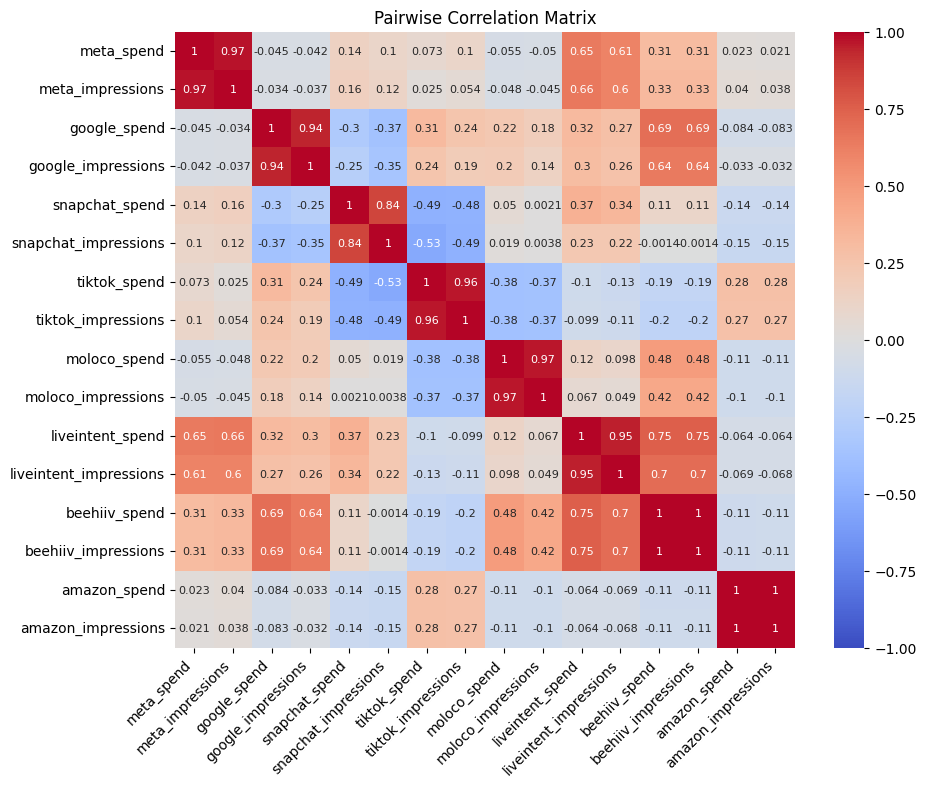

In [5]:
# drop response variable for heatmap and VIF
corr_data = mocha_subscriptions.drop(columns=['subscriptions', 'date'])

# Compute the pairwise correlation matrix
corr_matrix = corr_data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, annot_kws={"fontsize": 8})
plt.title('Pairwise Correlation Matrix')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.show()

### Heatmap Results

The pairwise correlation heatmap reveals several channel pairs with potential interactions. Some of these are:

* Meta and LiveIntent
* Google and Beehiiv
* Snapchat and TikTok
* LiveIntent and BeeHiiv

This list is not extensive nor ridgedly constructed. Furthermore, these pairs are *theorized* to be interacting based upon an arbitrary correlation cutoff. Further and more sophisticated causality testing will need to be used in order to determine if they will fit well within the model.

## Variance Inflation Factor (VIF)

In [6]:
vif_data = pd.DataFrame()
vif_data["Feature"] = corr_data.columns

vif_data["VIF"] = [variance_inflation_factor(corr_data.values, i)
                          for i in range(len(corr_data.columns))]
vif_data

,Feature,VIF
0,meta_spend,3.323567e+01
1,meta_impressions,3.069986e+01
2,google_spend,8.747860e+01
3,google_impressions,4.116332e+01
4,snapchat_spend,3.722198e+01
5,snapchat_impressions,3.009011e+01
6,tiktok_spend,4.569125e+01
7,tiktok_impressions,3.052867e+01
8,moloco_spend,3.297831e+01
9,moloco_impressions,3.084501e+01


### Variance Inflation Factor Results

Upon calculating the Variance Inflation Factor for all channels, we find all values are above 10. These results indicate a strong presence of multicollinearity, reinforcing our previous intuition that interactions are present among the channels.

## Residual Analysis

In [7]:
target = "subscriptions"
channels = ["meta_spend", "google_spend", "snapchat_spend"]

X = mocha_subscriptions[channels]
y = mocha_subscriptions[target]

model = LinearRegression()
model.fit(X, y)

mocha_subscriptions["prediction"] = model.predict(X)
mocha_subscriptions["residual"] = y - mocha_subscriptions["prediction"]

results = []

for ch in channels:
    pearson_corr, pearson_p = pearsonr(mocha_subscriptions["residual"], mocha_subscriptions[ch])
    spearman_corr, spearman_p = spearmanr(mocha_subscriptions["residual"], mocha_subscriptions[ch])

    results.append({
        "channel": ch,
        "pearson_corr": pearson_corr,
        "pearson_p": pearson_p,
        "spearman_corr": spearman_corr,
        "spearman_p": spearman_p
    })

results_df = (
    pd.DataFrame(results)
      .sort_values("pearson_corr", ascending=False)
)

results_df

,channel,pearson_corr,pearson_p,spearman_corr,spearman_p
0,meta_spend,2.359224e-16,1.0,-0.010088,0.932020
1,google_spend,-4.163336e-17,1.0,0.064672,0.584080
2,snapchat_spend,-3.950833e-16,1.0,-0.004132,0.972129


### Residual Diagnostic Results
Examining Pearson and Spearman correlations between model residuals and individual channel spends as standard diagnostic checks for misspecification or omitted structure. Across all channels, correlations are effectively zero with very high p-values, indicating no statistically significant linear or monotonic dependence between residuals and channel inputs. This suggests that the model has absorbed the systematic channel-level signal, leaving residual variation consistent with noise rather than unmodeled effects.

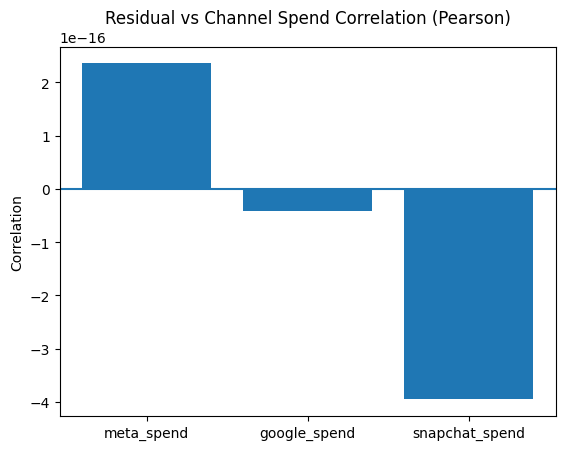

In [8]:
plt.figure()
plt.bar(results_df["channel"], results_df["pearson_corr"])
plt.axhline(0)
plt.ylabel("Correlation")
plt.title("Residual vs Channel Spend Correlation (Pearson)")
plt.show()

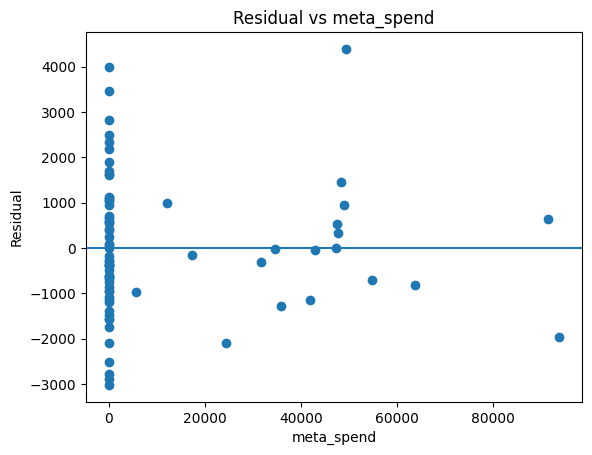

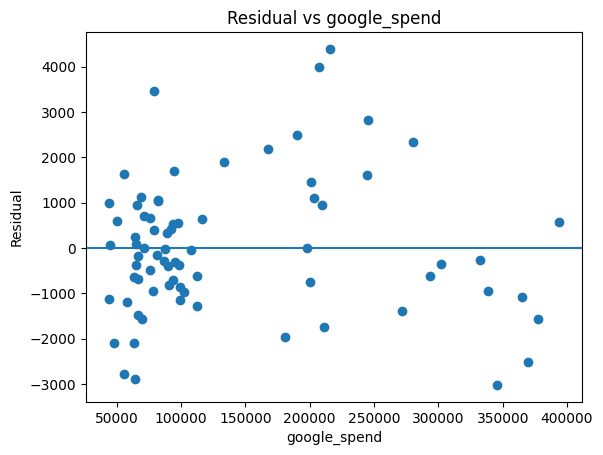

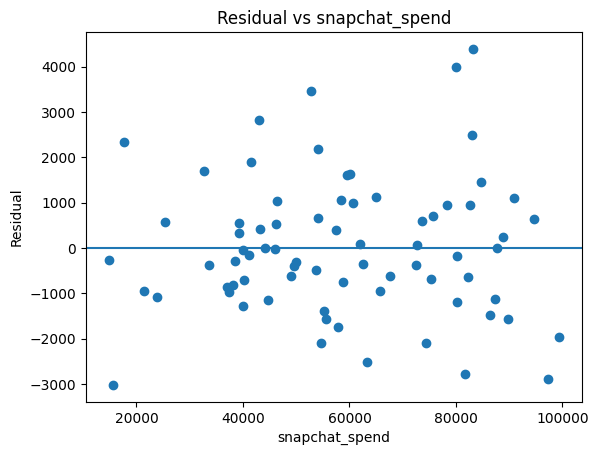

In [9]:
top_channels = results_df["channel"]

for ch in top_channels:
    plt.figure()
    plt.scatter(mocha_subscriptions[ch], mocha_subscriptions["residual"])
    plt.axhline(0)
    plt.xlabel(ch)
    plt.ylabel("Residual")
    plt.title(f"Residual vs {ch}")
    plt.show()

In [10]:
for ch in channels:
    corr, p = pearsonr(mocha_subscriptions["residual"].iloc[1:], mocha_subscriptions[ch].shift(1).iloc[1:])
    print(f"{ch} (lagged): corr={corr:.3f}, p={p:.3f}")

meta_spend (lagged): corr=0.058, p=0.626
google_spend (lagged): corr=-0.021, p=0.857
snapchat_spend (lagged): corr=0.173, p=0.143


Lagged Pearson correlation tests indicate no statistically significant dependence between model residuals and one-period–lagged channel spends suggesting that short-run dynamic effects are adequately captured by the model.

## Results

**Heatmap**:
We produced a pairwise correlation matrix, or heatmap, that visualized potential interactions between channels. Many pairs, such as Meta and LiveIntent, Google and BeeHiiv, and Snapchat and Tiktok, were highly correlated, supporting the theory that channel spend and impression are linked.

**Variance Inflation Factor**:
We caculated the Variance Inflation Factor (VIF) for all channel, all of which were above 10. These results point to the presence of multicollinearity among the channels.

**Residuals**:
We examined whether model residuals are correlated with contemporaneous or lagged channel spend as a diagnostic for omitted cross-channel or dynamic effects. Across all channels, correlations are small and statistically insignificant, indicating no evidence of systematic dependence between residuals and channel inputs.